In [3]:
# In this Notebook we clean the data from duplicates , Handle missing values and edit the columns values like the {age} column 

In [4]:
# Constants
DATA_PATH = '../data/raw/train_users_2.csv'
EXPORT_PATH = "../data/processed/1_preprocessed_df.pkl"
EXPORT_PATH2 = "../data/processed/2_preprocessed_df.pkl"

In [5]:
# Load packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import pickle


#import Machine Learning libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

C:\Users\user\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# Read Data 
raw_df = pd.read_pickle(EXPORT_PATH)

In [7]:
df = raw_df.copy()

In [8]:
# 01 Checking the Duplicates and Drop them

In [9]:
df.duplicated().sum()

0

In [10]:
#we don't have any duplicates
#02 Finding Null Values

In [11]:
df.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [12]:
df.isnull().sum()/len(df)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

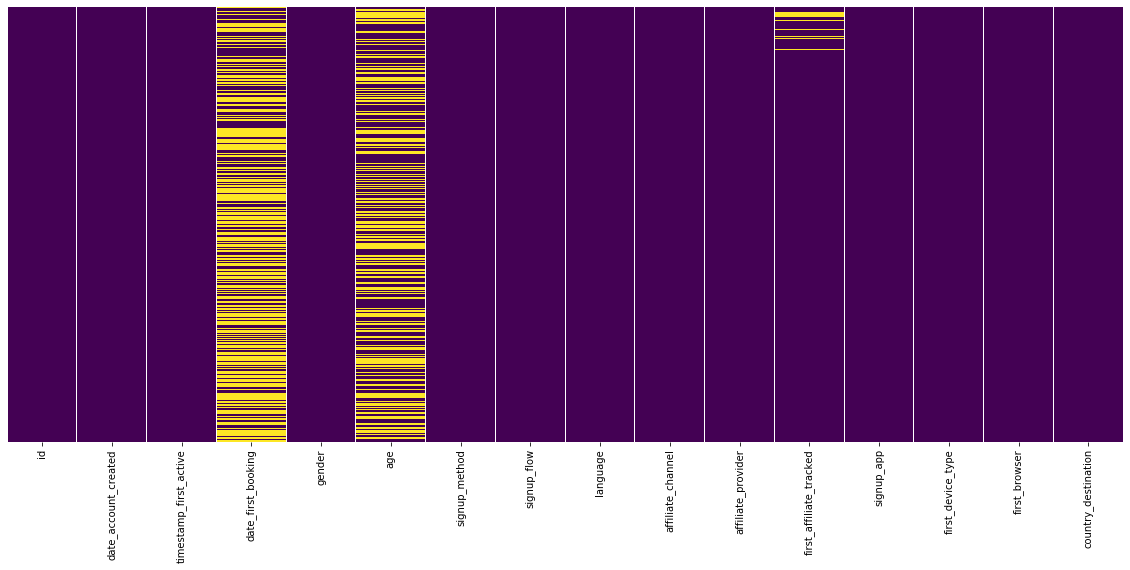

In [13]:
#Null value Analysis percejtage
plt.figure(figsize = (20,8))
sns.heatmap(df.isnull(), yticklabels = False, cbar = False ,cmap='viridis')

In [14]:
df_length = len(df)

print('Date first booking null %% = ',(df['date_first_booking'].isnull().sum()/df_length*100),'%\n')
print('Age null %% = ',(df['age'].isnull().sum()/df_length*100),'%\n')
print('first_affiliate_tracked null %% = ',(df['first_affiliate_tracked'].isnull().sum()/df_length*100),'%\n')

Date first booking null %% =  58.34734904029496 %

Age null %% =  41.222575673105304 %

first_affiliate_tracked null %% =  2.84140153946339 %



In [15]:
#Here we have more than one option :
#1. Dropping the whole column which have more than 58% of data Nulls
#2. Or keep it and use a model is not affected by te number of nulls as the XGboost.
#Checking the number of records with 3 null values in the same row

In [17]:
#initialize an empty list to store records with more than 3 nulls 
records_with_nulls = []

#iterate through each row in the dataframe 
for index, row in df.iterrows():

    #count the number of null values in each row 
    num_nulls = row.isnull().sum()

    #if number of null values is greater than 3, append the index to records_with_nulls list 
    if num_nulls >= 3: 
        records_with_nulls.append(index)
        

#print out the indices for records with more than 3 null values  
print(len(records_with_nulls))

2656


In [18]:
print("The number of rows that have 3 Nulls = ",len(records_with_nulls))

The number of rows that have 3 Nulls =  2656


In [19]:
df = df.drop(columns = ['date_first_booking'])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       213451 non-null  object        
 1   date_account_created     213451 non-null  datetime64[ns]
 2   timestamp_first_active   213451 non-null  datetime64[ns]
 3   gender                   213451 non-null  object        
 4   age                      125461 non-null  float64       
 5   signup_method            213451 non-null  object        
 6   signup_flow              213451 non-null  int64         
 7   language                 213451 non-null  object        
 8   affiliate_channel        213451 non-null  object        
 9   affiliate_provider       213451 non-null  object        
 10  first_affiliate_tracked  207386 non-null  object        
 11  signup_app               213451 non-null  object        
 12  first_device_typ

In [21]:
print(len(df[df['age'] > 120]))
print(len(df[df['age'] < 18]))

781
158


In [22]:
df.age.describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [23]:
df.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
gender                         0
age                        87990
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked     6065
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

In [24]:
df.isnull().sum().sum()

94055

In [25]:
#Handling Unkowns

In [26]:
# Function to ease handling these values in the test dataset later
def handle_unknown(df):
    """Reduce values '-unknown-' in both gender and first_browser columns to np.nan"""
    print(f"Operation affected {df.loc[df[df['gender'] == '-unknown-'].index].shape[0]:,} records in the gender column.")
    df.loc[df[df['gender'] == '-unknown-'].index, 'gender'] = np.nan
    display(df['gender'].value_counts(dropna=False))
    
    print(f"\nOperation affected {df.loc[df[df['first_browser'] == '-unknown-'].index].shape[0]:,} records in the first_browser column.")
    df.loc[df[df['first_browser'] == '-unknown-'].index, 'first_browser'] = np.nan
    display(df['first_browser'].value_counts(dropna=False))

# gender and first_browser column in user_data dataset
handle_unknown(df)

Operation affected 95,688 records in the gender column.


NaN       95688
FEMALE    63041
MALE      54440
OTHER       282
Name: gender, dtype: int64


Operation affected 27,266 records in the first_browser column.


Chrome                  63845
Safari                  45169
Firefox                 33655
NaN                     27266
IE                      21068
Mobile Safari           19274
Chrome Mobile            1270
Android Browser           851
AOL Explorer              245
Opera                     188
Silk                      124
Chromium                   73
BlackBerry Browser         53
Maxthon                    46
IE Mobile                  36
Apple Mail                 36
Sogou Explorer             33
Mobile Firefox             30
SiteKiosk                  24
RockMelt                   24
Iron                       17
IceWeasel                  13
Pale Moon                  12
SeaMonkey                  11
CometBird                  11
Yandex.Browser             11
Camino                      9
TenFourFox                  8
CoolNovo                    6
wOSBrowser                  6
Avant Browser               4
Opera Mini                  4
Mozilla                     3
TheWorld B

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64


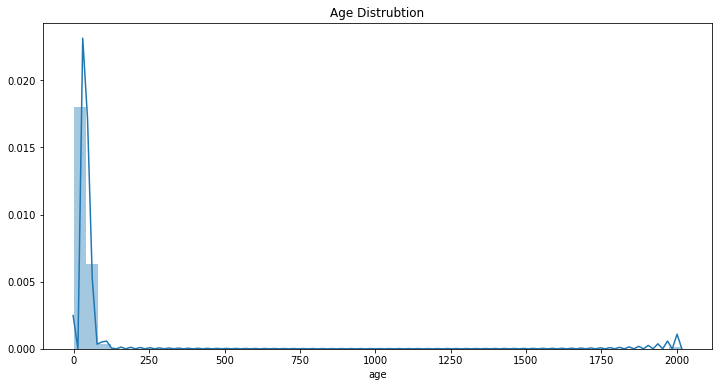

In [27]:
print(df['age'].describe())

plt.figure(figsize=(12,6))
sns.distplot(df.age.dropna())
plt.title('Age Distrubtion')
plt.show();

In [28]:
# Functions to ease the test data processing later

def calc_age_from_bdate(df, LB=1900, UB=2000):
    """
    Calculate the age by subtracting the presumed birth date from the account creation date
    """
    
    bdate_index = df[np.logical_and(df['age'] > LB, df['age'] < UB)]['age'].index
    print(f"Operation affected {df.loc[bdate_index].shape[0]:,} records.")
    df.loc[bdate_index, 'age'] = (df.loc[bdate_index]['date_account_created'].dt.year - df.loc[bdate_index]['age'])
    
    
def nullify_age_outliers(df, LB=18, UB=120):
    """
    Reduce records containing age values outside the interval [LB, UB] exclusive to np.nan.
    """
    
    print(f"Upperbound Operation affected {df.loc[df[df['age'] > UB].index].shape[0]:,} records.")
    df.loc[df[df['age'] > UB].index, 'age'] = np.nan
    
    print(f"Lowerbound Operation affected {df.loc[df[df['age'] < LB].index].shape[0]:,} records.")
    df.loc[df[df['age'] < LB].index, 'age'] = np.nan

In [29]:
# Calculate the age by subtracting the presumed birth date from the account creation date 

calc_age_from_bdate(df)

Operation affected 29 records.


In [30]:
# Reduce records containing age values outside the interval [18, 120] exclusive to np.nan

nullify_age_outliers(df)

Upperbound Operation affected 752 records.
Lowerbound Operation affected 158 records.


count    124551.000000
mean         37.452835
std          13.943147
min          18.000000
25%          28.000000
50%          34.000000
75%          43.000000
max         115.000000
Name: age, dtype: float64


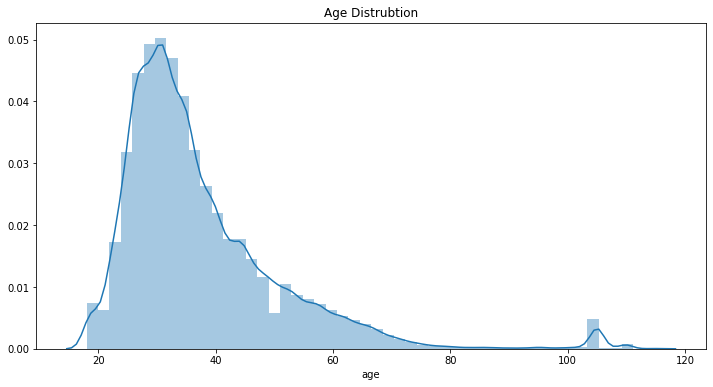

In [31]:
print(df['age'].describe())

plt.figure(figsize=(12,6))
sns.distplot(df.age.dropna())
plt.title('Age Distrubtion')
plt.show()

In [32]:
df.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
gender                     95688
age                        88900
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked     6065
signup_app                     0
first_device_type              0
first_browser              27266
country_destination            0
dtype: int64

In [33]:
df.isnull().sum().sum()

217919

In [34]:
#Handling Null values

In [35]:
MEDIAN_AGE = df.age.median()
FIRST_AFFILIATE_TRACKED = 'untracked'

In [36]:
# Functions to ease test data processing later

def fill_age_nulls(df):
    """
    Fill the null values in both age column.
    Must set the Constant MEDIAN_AGE before using the function.
    """
    
    print(f"Operation affected {df.isna().sum().age:,} records in the age column.")
    df.age.fillna(MEDIAN_AGE, inplace=True)
    
    
def fill_FAT_nulls(df):
    """
    Fill the null values in first_affiliate_tracked column.
    Must set the Constant FIRST_AFFILIATE_TRACKED before using the function.
    """
    
    print(f"Operation affected {df.isna().sum().first_affiliate_tracked:,} records in the first_affiliate_tracked column.")
    df.first_affiliate_tracked.fillna(FIRST_AFFILIATE_TRACKED, inplace=True)

In [37]:
fill_age_nulls(df)
fill_FAT_nulls(df)

Operation affected 88,900 records in the age column.
Operation affected 6,065 records in the first_affiliate_tracked column.


In [38]:
df.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
gender                     95688
age                            0
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked        0
signup_app                     0
first_device_type              0
first_browser              27266
country_destination            0
dtype: int64

In [39]:
df.isnull().sum().sum()

122954

In [40]:
#we still have nulls in the {Gender & first_Browser} We can handle that by:
#Using Machine learning model like KNN model.
#Using random values.
#Use the most common value.
#Let them as they're and use a robust model with Nulls like XGboost.

In [41]:
# Filling with the most common value
# df['gender'].fillna(df['gender'].mode()[0], inplace=True)

In [42]:
df.gender.value_counts()

FEMALE    63041
MALE      54440
OTHER       282
Name: gender, dtype: int64

In [43]:
df.gender.isna().sum()

95688

In [44]:
df

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaN,34.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,2014-06-30 23:56:36,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,2014-06-30 23:57:19,NaN,34.0,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,2014-06-30 23:57:54,NaN,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,2014-06-30 23:58:22,NaN,34.0,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


In [45]:
#label encoding the gender column 
le = LabelEncoder() 
df['gender']= le.fit_transform(df['gender']) 
print(df) 

#applying knn imputer on the nans  
imputer = KNNImputer(n_neighbors=2) 
df['gender'] = imputer.fit_transform(df[['gender']]) 

 #converting back to original labels  
# df['gender'] = le.inverse_transform(df['gender']) 

#final output  
print(df.age.value_counts())

                id date_account_created timestamp_first_active  gender   age  \
0       gxn3p5htnn           2010-06-28    2009-03-19 04:32:55       3  34.0   
1       820tgsjxq7           2011-05-25    2009-05-23 17:48:09       1  38.0   
2       4ft3gnwmtx           2010-09-28    2009-06-09 23:12:47       0  56.0   
3       bjjt8pjhuk           2011-12-05    2009-10-31 06:01:29       0  42.0   
4       87mebub9p4           2010-09-14    2009-12-08 06:11:05       3  41.0   
...            ...                  ...                    ...     ...   ...   
213446  zxodksqpep           2014-06-30    2014-06-30 23:56:36       1  32.0   
213447  mhewnxesx9           2014-06-30    2014-06-30 23:57:19       3  34.0   
213448  6o3arsjbb4           2014-06-30    2014-06-30 23:57:54       3  32.0   
213449  jh95kwisub           2014-06-30    2014-06-30 23:58:22       3  34.0   
213450  nw9fwlyb5f           2014-06-30    2014-06-30 23:58:24       3  34.0   

       signup_method  signup_flow langu

In [48]:
df.gender.isna().sum()

0

In [49]:
df.isna().sum()

id                             0
date_account_created           0
timestamp_first_active         0
gender                         0
age                            0
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked        0
signup_app                     0
first_device_type              0
first_browser              27266
country_destination            0
dtype: int64

In [50]:
df.isna().sum().sum()

27266

In [51]:
#label encoding the gender column 
le = LabelEncoder() 
df['first_browser']= le.fit_transform(df['first_browser']) 
# print(df) 

#applying knn imputer on the nans  
imputer = KNNImputer(n_neighbors=2) 
df['first_browser'] = imputer.fit_transform(df[['first_browser']]) 

 #converting back to original labels  
# df['first_browser'] = le.inverse_transform(df['first_browser']) 

#final output  
print(df.first_browser.value_counts())

7.0     63845
40.0    45169
16.0    33655
51.0    27266
20.0    21068
28.0    19274
8.0      1270
1.0       851
0.0       245
32.0      188
42.0      124
9.0        73
5.0        53
26.0       46
21.0       36
2.0        36
45.0       33
27.0       30
43.0       24
39.0       24
24.0       17
23.0       13
37.0       12
41.0       11
10.0       11
49.0       11
6.0         9
47.0        8
13.0        6
50.0        6
4.0         4
33.0        4
29.0        3
48.0        2
17.0        2
11.0        2
31.0        2
44.0        2
14.0        2
34.0        2
15.0        1
46.0        1
19.0        1
35.0        1
3.0         1
30.0        1
36.0        1
18.0        1
12.0        1
25.0        1
38.0        1
22.0        1
Name: first_browser, dtype: int64


In [52]:
df.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

In [53]:
# Exporting Data
df.to_pickle(EXPORT_PATH2)